     |████████████████████████████████| 101 kB 526 kB/s ta 0:00:01
     |████████████████████████████████| 2.8 MB 1.3 MB/s eta 0:00:01
  Created wheel for pyace: filename=pyace-0.1.1-py3-none-any.whl size=14070 sha256=a30ea977571f446d3a941a585fbbb82b4c05d6ba3bba7132cb7bf23c7b236ade
  Stored in directory: /Users/zacharyserviss/Library/Caches/pip/wheels/fb/38/54/681ae7b42bed5fcf30e84020b9aa004d1cebdb3f17c8dfd56f
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=b1c8e52f53a92e7fe8f1f8ad1dfcb7172033bfdf5ab451efc98a12ce166cf64a
  Stored in directory: /Users/zacharyserviss/Library/Caches/pip/wheels/12/d8/36/e9b7c617ca8be398dcc48621c539d0cb1d41ff04e4367fc235
Successfully built pyace theano


ImportError: cannot import name 'simpleace' from partially initialized module 'pyace' (most likely due to a circular import) (/Users/zacharyserviss/opt/anaconda3/lib/python3.9/site-packages/pyace/__init__.py)

In [85]:
import pyaudio
import wave

# the file name output you want to record into
filename = "recorded.wav"
# set the chunk size of 1024 samples
chunk = 1024
# sample format
FORMAT = pyaudio.paInt16
# mono, change to 2 if you want stereo
channels = 1
# 44100 samples per second
sample_rate = 44100
record_seconds = 3
# initialize PyAudio object
p = pyaudio.PyAudio()
# open stream object as input & output
stream = p.open(format=FORMAT,
                channels=channels,
                rate=sample_rate,
                input=True,
                output=True,
                frames_per_buffer=chunk)
frames = []
print("Recording...")
for i in range(int(sample_rate / chunk * record_seconds)):
    data = stream.read(chunk)
    # if you want to hear your voice while recording
    # stream.write(data)
    frames.append(data)
print("Finished recording.")
# stop and close stream
stream.stop_stream()
stream.close()
# terminate pyaudio object
p.terminate()
# save audio file
# open the file in 'write bytes' mode
wf = wave.open(filename, "wb")
# set the channels
wf.setnchannels(channels)
# set the sample format
wf.setsampwidth(p.get_sample_size(FORMAT))
# set the sample rate
wf.setframerate(sample_rate)
# write the frames as bytes
wf.writeframes(b"".join(frames))
# close the file
wf.close()

Recording...
Finished recording.


/var/folders/dj/4t0nmj5d2pv4sfpjw2t429sm0000gn/T/ipykernel_39809/3849241525.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal = np.fromstring(signal,np.int64)


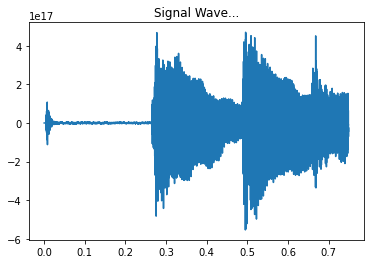

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys


spf = wave.open("recorded.wav", "r")

# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal,np.int64)
fs = spf.getframerate()

# If Stereo
if spf.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)


Time = np.linspace(0, len(signal) / fs, num=len(signal))

plt.figure(1)
plt.title("Signal Wave...")
plt.plot(Time, signal)
plt.show()

In [87]:
import os
import numpy as np
from matplotlib import pyplot as plt
import librosa

import sys
sys.path.append('..')
import libfmp.b
import libfmp.c3
import libfmp.c4


%matplotlib inline

def compute_chromagram_from_filename(fn_wav, Fs=22050, N=4096, H=2048, gamma=None, version='STFT', norm='2'):
    """Compute chromagram for WAV file specified by filename

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        fn_wav (str): Filenname of WAV
        Fs (scalar): Sampling rate (Default value = 22050)
        N (int): Window size (Default value = 4096)
        H (int): Hop size (Default value = 2048)
        gamma (float): Constant for logarithmic compression (Default value = None)
        version (str): Technique used for front-end decomposition ('STFT', 'IIS', 'CQT') (Default value = 'STFT')
        norm (str): If not 'None', chroma vectors are normalized by norm as specified ('1', '2', 'max')
            (Default value = '2')

    Returns:
        X (np.ndarray): Chromagram
        Fs_X (scalar): Feature reate of chromagram
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling rate of audio signal
        x_dur (float): Duration (seconds) of audio signal
    """
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_dur = x.shape[0] / Fs
    if version == 'STFT':
        # Compute chroma features with STFT
        X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
        if gamma is not None:
            X = np.log(1 + gamma * np.abs(X) ** 2)
        else:
            X = np.abs(X) ** 2
        X = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
    if version == 'CQT':
        # Compute chroma features with CQT decomposition
        X = librosa.feature.chroma_cqt(y=x, sr=Fs, hop_length=H, norm=None)
    if version == 'IIR':
        # Compute chroma features with filter bank (using IIR elliptic filter)
        X = librosa.iirt(y=x, sr=Fs, win_length=N, hop_length=H, center=True, tuning=0.0)
        if gamma is not None:
            X = np.log(1.0 + gamma * X)
        X = librosa.feature.chroma_cqt(C=X, bins_per_octave=12, n_octaves=7,
                                       fmin=librosa.midi_to_hz(24), norm=None)
    if norm is not None:
        X = libfmp.c3.normalize_feature_sequence(X, norm='2')
    Fs_X = Fs / H
    return X, Fs_X, x, Fs, x_dur

def plot_chromagram_annotation(ax, X, Fs_X, ann, color_ann, x_dur, cmap='gray_r', title=''):
    """Plot chromagram and annotation

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        ax: Axes handle
        X: Feature representation
        Fs_X: Feature rate
        ann: Annotations
        color_ann: Color for annotations
        x_dur: Duration of feature representation
        cmap: Color map for imshow (Default value = 'gray_r')
        title: Title for figure (Default value = '')
    """
    libfmp.b.plot_chromagram(X, Fs=Fs_X, ax=ax,
                             chroma_yticks=[0, 4, 7, 11], clim=[0, 1], cmap=cmap,
                             title=title, ylabel='Chroma', colorbar=True)
    libfmp.b.plot_segments_overlay(ann, ax=ax[0], time_max=x_dur,
                                   print_labels=False, colors=color_ann, alpha=0.1)
def get_chord_labels(ext_minor='m', nonchord=False):
    """Generate chord labels for major and minor triads (and possibly nonchord label)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        ext_minor (str): Extension for minor chords (Default value = 'm')
        nonchord (bool): If "True" then add nonchord label (Default value = False)

    Returns:
        chord_labels (list): List of chord labels
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_labels_maj = chroma_labels
    chord_labels_min = [s + ext_minor for s in chroma_labels]
    chord_labels = chord_labels_maj + chord_labels_min
    if nonchord is True:
        chord_labels = chord_labels + ['N']
    return chord_labels

def generate_chord_templates(nonchord=False):
    """Generate chord templates of major and minor triads (and possibly nonchord)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_templates (np.ndarray): Matrix containing chord_templates as columns
    """
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
    num_chord = 24
    if nonchord:
        num_chord = 25
    chord_templates = np.ones((12, num_chord))
    for shift in range(12):
        chord_templates[:, shift] = np.roll(template_cmaj, shift)
        chord_templates[:, shift+12] = np.roll(template_cmin, shift)  
    return chord_templates

def chord_recognition_template(X, norm_sim='1', nonchord=False):
    """Conducts template-based chord recognition
    with major and minor triads (and possibly nonchord)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        X (np.ndarray): Chromagram
        norm_sim (str): Specifies norm used for normalizing chord similarity matrix (Default value = '1')
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_sim (np.ndarray): Chord similarity matrix
        chord_max (np.ndarray): Binarized chord similarity matrix only containing maximizing chord
    """
    chord_templates = generate_chord_templates(nonchord=nonchord)
    X_norm = libfmp.c3.normalize_feature_sequence(X, norm='2')
    chord_templates_norm = libfmp.c3.normalize_feature_sequence(chord_templates, norm='2')
    chord_sim = np.matmul(chord_templates_norm.T, X_norm)
    if norm_sim is not None:
        chord_sim = libfmp.c3.normalize_feature_sequence(chord_sim, norm=norm_sim)
    # chord_max = (chord_sim == chord_sim.max(axis=0)).astype(int)
    chord_max_index = np.argmax(chord_sim, axis=0)
    chord_max = np.zeros(chord_sim.shape).astype(np.int32)
    for n in range(chord_sim.shape[1]):
        chord_max[chord_max_index[n], n] = 1

    return chord_sim, chord_max                                   

# Compute chroma features
fn_wav = "recorded.wav"
N = 4096
H = 2048
X_STFT, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
X_IIR, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=100, version='IIR')
X_CQT, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, version='CQT')


X = X_STFT
chord_sim, chord_max = chord_recognition_template(X, norm_sim='max')
chord_labels = get_chord_labels(nonchord=False)
chord_templates = generate_chord_templates() 
X_chord = np.matmul(chord_templates, chord_max)

i=0
max = 0
for x in chord_max:
    print(chord_labels[i],x,sum(x))
    if sum(x) > max:
        max = sum(x)
        max_chord = chord_labels[i]
    i+=1

print(max_chord)


C [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 0
C# [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1
D [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1
D# [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 0
E [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0] 2
F [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 0
F# [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 0
G [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 2
G# [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 0
A [0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1] 22
A# [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 0
B [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 0
Cm [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1
C#m [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [88]:
# A Chord is played and read in to the program

print("Chord played: ", max_chord, "\n")
# Read in the file  with the chord progression lists
with open('ChordKeys.txt', 'r') as f:
        for line in f:
            chords = line.split()
            if chords:
                if(chords[0] == max_chord):
                    #print(chords)
                    break;

print("Chords in the Key of ", max_chord, ":")                
print(chords,"\n")
# Possible chord progressions

# A     Bb     B     C     C#     D     Eb     E     F     F#     G     G# 

# Example - A 

# Define Array of 7 and Place each note into their place in the array
    #[i][ii][iii][IV][V][vi][vii]
    #[A][B][C#][D][E][F#][G#]

pop_Progression = [0]*4
pop = [int(0),int(4),int(5),int(3)]
j = 0
for i in pop:
    pop_Progression[j] = chords[i]
    j = j+1
print ("Chords in the Progression:")
print(pop_Progression,"\n")

blues_Progression = [0]*3
blues = [int(0),int(3),int(4)]
j = 0
for i in blues:
    blues_Progression[j] = chords[i]
    j = j+1
print ("Chords in the Progression: ")
print(blues_Progression,"\n")


#I – V – vi – iii – IV – I – IV – V
cannon_Progression = [0]*8
cannon = [int(0),int(4),int(5),int(2),int(3),int(0),int(3),int(4)]
j = 0
for i in cannon:
    cannon_Progression[j] = chords[i]
    j = j+1
print ("Chords in the Progression: ")
print(cannon_Progression)





Chord played:  A 

Chords in the Key of  A :
['A', 'Bm', 'C#m', 'D', 'E', 'F#m', 'G#dim'] 

Chords in the Progression:
['A', 'E', 'F#m', 'D'] 

Chords in the Progression: 
['A', 'D', 'E'] 

Chords in the Progression: 
['A', 'E', 'F#m', 'C#m', 'D', 'A', 'D', 'E']
